In [1]:
from transformers import AutoModel, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import our models. The package will take care of downloading the models automatically

model_id = "princeton-nlp/unsup-simcse-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id).to(device)

/workspace/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
paragraph = """
RNNs
Recurrent Neural Networks (RNNs) like LSTMs and GRUs have long been the model of choice for sequential data, making RNNs a popular choice for both the encoder and decoder



The Encoders job is to take in an input sequence and output a context vector / thought vector (i.e. the encoder RNN’s final hidden state. Or if the encoder is a bidirectional RNN (bi-RNN) it could be the concatenation of both directions’ final hidden states). This context vector is the input for the Decoder whose job is to output a different sequence (e.g. the translation or reply of the input text, etc).



Unfortunately the performance drops drastically for longer sentences because signals from earlier inputs get diluted as they pass down the longer sequences.


One way to keep earlier signals strong is to use skip-connections that feed every hidden state of the encoder RNN into every input of the decoder RNN (rather than just the encoder’s final hidden state being fed into the decoder’s initial state).


However, there is then the question of how to combine multiple hidden state into a single context vector. You could simply concatenate them.


Or you could sum them together (or average them, or take the max, or min, etc)



However all these suggestions make the assumption that all hidden states (and their corresponding input word) are equally important. We can do better with a weighted sum, e.g. Tf-idf weighted sum of vectors (to pay more attention to relatively rarer words)



However, this also assumes that the same hidden states (and inputs) will be more/less important to each output identically, whereas the importance of inputs depends on the specific output being predicted (is often the case that some words are more relevant for some predictions than others)



""".strip()

tokens = tokenizer.encode(paragraph, return_tensors="pt")[0]

In [23]:
tokens.shape

torch.Size([411])

In [24]:
import math

growing_factor = 1.1
current_length = 2

progressive_tokens = []
progressive_masks = []

while current_length <= len(tokens):
    current_length = math.ceil(current_length * growing_factor)
    current_token = tokens[:current_length]
    current_mask = torch.ones_like(current_token)
    # fill with zeros at the end until we reach the desired length
    if len(current_token) < tokens.shape[0]:
        current_token = torch.cat(
            [current_token, torch.zeros(tokens.shape[0] - current_length).long()]
        )
        current_mask = torch.cat(
            [current_mask, torch.zeros(tokens.shape[0] - current_length).long()]
        )

    progressive_tokens.append(current_token)
    progressive_masks.append(current_mask)


progressive_tokens = torch.stack(progressive_tokens).to(device)
progressive_masks = torch.stack(progressive_masks).to(device)

print("Progressive tokens shape:", progressive_tokens.shape)

Progressive tokens shape: torch.Size([44, 411])


In [25]:
model.eval()

with torch.no_grad():
    progressive_embeddings = model(
        input_ids=progressive_tokens, attention_mask=progressive_masks
    ).pooler_output

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
progressive_embeddings_2d = pca.fit_transform(progressive_embeddings.cpu())

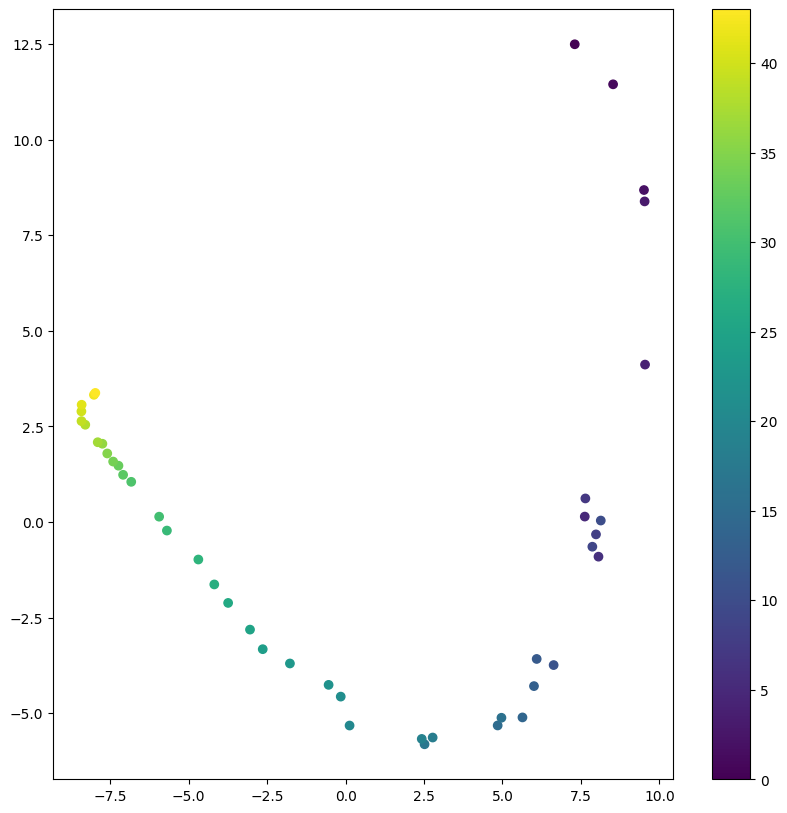

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(
    progressive_embeddings_2d[:, 0],
    progressive_embeddings_2d[:, 1],
    c=range(len(progressive_embeddings_2d)),
    cmap="viridis",
)
plt.colorbar()
plt.show()